In [1]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras import models, layers

data_path_mini = '../data/raw/kaggle_mini_subsample'

In [2]:
BATCH_SIZE = 100
TARGET_SIZE = [128, 128]
image_generator = ImageDataGenerator().flow_from_directory(data_path_mini, batch_size=BATCH_SIZE, target_size=TARGET_SIZE);
images, labels = next(image_generator)
images_scaled = images / 255

Found 100 images belonging to 2 classes.


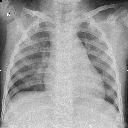

{'NORMAL': 0, 'PNEUMONIA': 1}


In [3]:
display(array_to_img(images[99]))
print(image_generator.class_indices)

In [49]:
images_scaled.shape

(100, 128, 128, 3)

In [17]:
labels.shape

(100, 2)

In [47]:
images_scaled.reshape(-1, 2).shape

(2457600, 2)

In [50]:
SHAPE = images_scaled.shape[1]

model = models.Sequential()
model.add(layers.Dense(100, activation='relu', input_shape = images_scaled.shape))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
history = model.fit(x=images_scaled, y=labels, epochs=120)

Epoch 1/120


ValueError: in user code:

    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\seths\anaconda3\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 2) and (None, 128, 128, 2) are incompatible
